In [2]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

load data
align fingerprints


Create utility functions.

In [99]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create molecular properties
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create evaluators
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))

# create utility function
utility_function = UtilityFunction(
    oracles = [
        log_S_oracle,
        log_P_oracle
    ],
    evaluators = [
        log_S_evaluator,
        log_P_evaluator
    ],
    strategy = lambda x: np.prod(x, axis=0)
)

In [91]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials):
        
        results = []
        for trial in range(num_trials):

            observations, info = drug_env.reset()

            round_ = 0
            pbar = tqdm(total = drug_env.budget)
            while True:
                round_ += 1
                action = drug_agent.act(observations)
                print(action)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                if terminated or truncated:
                    break
                pbar.n = len(drug_env.library)
                pbar.update()

            result = {
                'trial': trial,
                'epsilon': self.drug_agent.epsilon,
                'temperature': self.drug_agent.temperature,
                'num_analogs': self.drug_agent.num_analogs,
                'branch_factor': self.drug_agent.branch_factor
            }

            if terminated:
                cost = len(drug_env.library) - len(drug_env._library_0)
                result.update({'cost': cost, 'outcome': 1})
                break

            if truncated:
                result.update({'outcome': 0})
                break

            results.append(result)

        return results

In [122]:
drug_env = DrugEnv(
    library_designer,
    library = deck[[20]],
    assays = utility_function.oracles,
    budget = 200,
    utility_function = utility_function,
)

drug_agent = SequentialDrugAgent(
    action_space = drug_env.action_space,
    utility_function = utility_function,
    epsilon = 0.0,
    temperature = 0.0,
    num_analogs = 1,
    branch_factor = 2
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1)

  0%|          | 0/200 [00:00<?, ?it/s]

{'type': 0, 'molecules': [0], 'parameters': {'num_analogs': 1, 'temperature': 0.0}}
{'type': 1, 'molecules': [6, 10], 'parameters': {}}
{'type': 0, 'molecules': [6, 10], 'parameters': {'num_analogs': 1, 'temperature': 0.0}}
{'type': 1, 'molecules': [24, 16], 'parameters': {}}
{'type': 0, 'molecules': [24, 16], 'parameters': {'num_analogs': 1, 'temperature': 0.0}}
{'type': 1, 'molecules': [49, 24], 'parameters': {}}
{'type': 0, 'molecules': [49, 24], 'parameters': {'num_analogs': 1, 'temperature': 0.0}}
{'type': 1, 'molecules': [53, 49], 'parameters': {}}
{'type': 0, 'molecules': [53, 49], 'parameters': {'num_analogs': 1, 'temperature': 0.0}}
{'type': 1, 'molecules': [53, 49], 'parameters': {}}
{'type': 0, 'molecules': [53, 49], 'parameters': {'num_analogs': 1, 'temperature': 0.0}}
{'type': 1, 'molecules': [53, 49], 'parameters': {}}
{'type': 0, 'molecules': [53, 49], 'parameters': {'num_analogs': 1, 'temperature': 0.0}}
{'type': 1, 'molecules': [53, 49], 'parameters': {}}
{'type': 0, '

In [101]:
utility_function(experiment.drug_env.library[[60]])

array([0.47616585])

In [102]:
utility_function(library_designer.design(experiment.drug_env.library[60], temperature=0.0, size=10))

array([0.58314687, 0.4954505 , 0.74190855, 0.41933199, 0.13152788,
       0.3368363 , 0.48179502, 0.48233315, 0.6705218 , 0.37782961])

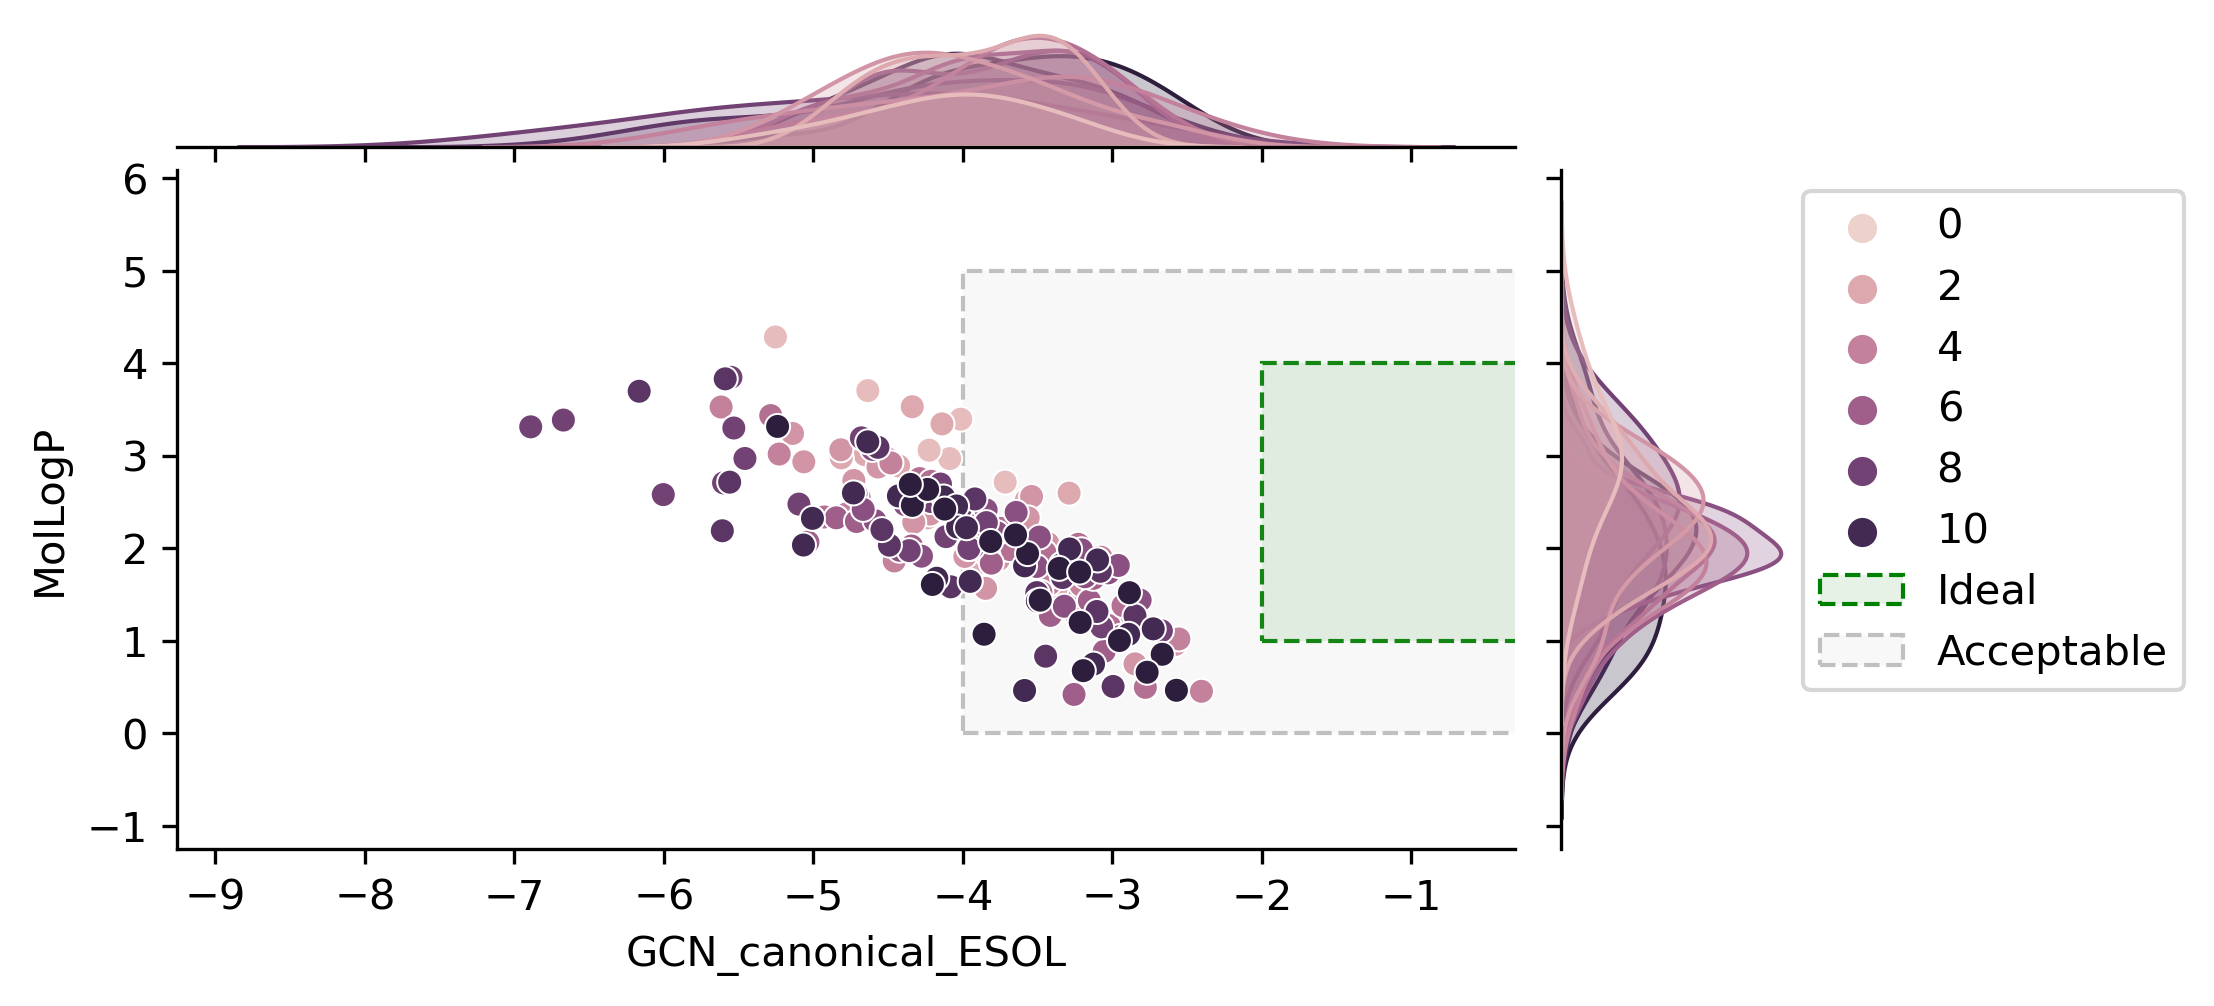

In [123]:
experiment.drug_env.utility_function.plot(experiment.drug_env.library)